# Notes for time series competitions

In [1]:
## Typical imports

import pandas as pd 

#pandas options
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np 
import statsmodels.api as sm  # <--- Yay! API! 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
% matplotlib inline 

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)

import itertools
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

## Manipulate, clean and inicial observation of data

- As always do train.head() after the import to check the dataframe format. Do train.info() to check datatypes and missing values. 
- Convert the Date or timestamp column into datetime objects. Set it as index and sort it

In [2]:
#import data (using bitcoin-data)
data = pd.read_csv("data_for_notes/bitcoin.csv")
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2017-01-01 00:00:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
1,2017-01-01 00:01:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2,2017-01-01 00:02:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
3,2017-01-01 00:03:00,973.36,973.36,973.36,973.36,0.040000,38.934400,973.360000
4,2017-01-01 00:04:00,973.36,973.40,973.36,973.39,5.458800,5313.529708,973.387871


In [3]:
# Example code to deal with create and deal with timeseries columns:

# This will convert to datetime object using the to_datetime method:
time_as_a_timestamp = pd.to_datetime(data.Timestamp, infer_datetime_format=True)

#Be carefull with European dates with ay first - use the following code:
european_dates = pd.Series(['05/04/2007',   # <-- April 5th, 2007
                            '13/04/2006', 
                            '27/12/2014'])

inferred_dates = pd.to_datetime(european_dates, dayfirst=True)


In [4]:
# After a column is converted to timestamp we can extract several atributes from it.
new = pd.DataFrame()
new['date'] = time_as_a_timestamp
new['day'] = new['date'].dt.day
new['month'] = new['date'].dt.month
new['year'] = new['date'].dt.year
new['hour'] = new['date'].dt.hour
new['minute'] = new['date'].dt.minute
new['second'] = new['date'].dt.second
new['day of the week'] = new['date'].dt.weekday
new['day of the week name'] = new['date'].dt.weekday_name
new['quarter'] = new['date'].dt.quarter
new['is it a leap year?'] = new['date'].dt.is_leap_year

new.head(2)

,date,day,month,year,hour,minute,second,day of the week,day of the week name,quarter,is it a leap year?
0,2017-01-01 00:00:00,1,1,2017,0,0,0,6,Sunday,1,False
1,2017-01-01 00:01:00,1,1,2017,0,1,0,6,Sunday,1,False


In [5]:
# Next set the date column as index and always sort it.

data.Timestamp = pd.to_datetime(data.Timestamp, infer_datetime_format=True)

data = data.set_index('Timestamp',    # <---- Set the index to be our timestamp data  
                      drop=True)      # <---- drop the original column

data = data.sort_index()
print('We have data between %s and %s' % (data.index.min(), data.index.max()))

# After this you can select directly from dataframe using data formats like:
data.loc['Jan 17th 2018'] # selecting every row on that date
data.loc['01/15/2018':'01/22/2018'].head() # selecting every row on between those dates (use american dates if using this format)

data.loc['01/17/2018 1:30PM':'01/17/2018 4:30PM' , 'Volume_(Currency)'] .head() # Selecting a particular Series

We have data between 2017-01-01 00:00:00 and 2018-03-27 00:00:00


Timestamp
2018-01-17 13:30:00    194664.293210
2018-01-17 13:31:00    134782.335550
2018-01-17 13:32:00     67075.196183
2018-01-17 13:33:00     90744.731937
2018-01-17 13:34:00    176266.835200
Name: Volume_(Currency), dtype: float64

### Observing and plotting data

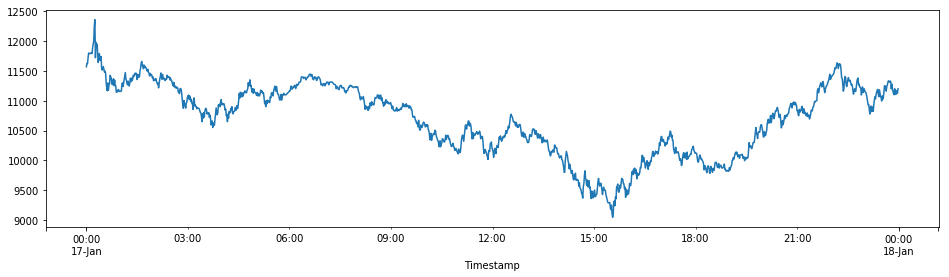

In [6]:
# You can plot directly like this:
data.loc['Jan 17th 2018'].Close.plot(figsize=(16, 4)); #(semicolon supresses output relating tho the plot object)

#### Using resampling with plots

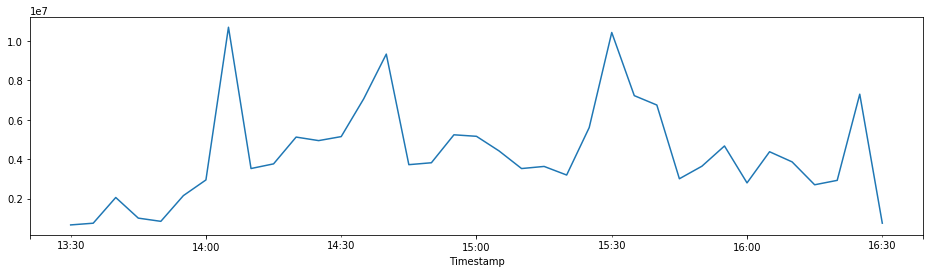

In [7]:
# you can use resampling to get for instance volume summed over 5 mins of trading:

data.loc['01/17/2018 1:30PM':'01/17/2018 4:30PM']['Volume_(Currency)'].resample('5 min').sum().plot(figsize=(16, 4));


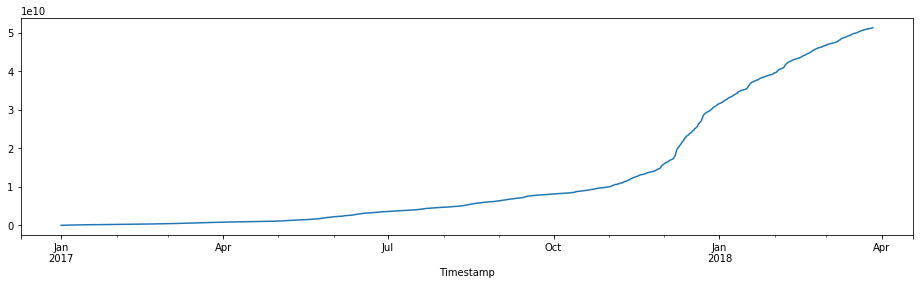

In [8]:
# use cumsum() to get the cumulative sum over time of a particular series:

data['Volume_(Currency)'].cumsum().plot(figsize=(16, 4));  # the mean weekly closing prices, since 2015

We can use several diferent [methods for groupby](http://pandas.pydata.org/pandas-docs/stable/api.html#groupby). 

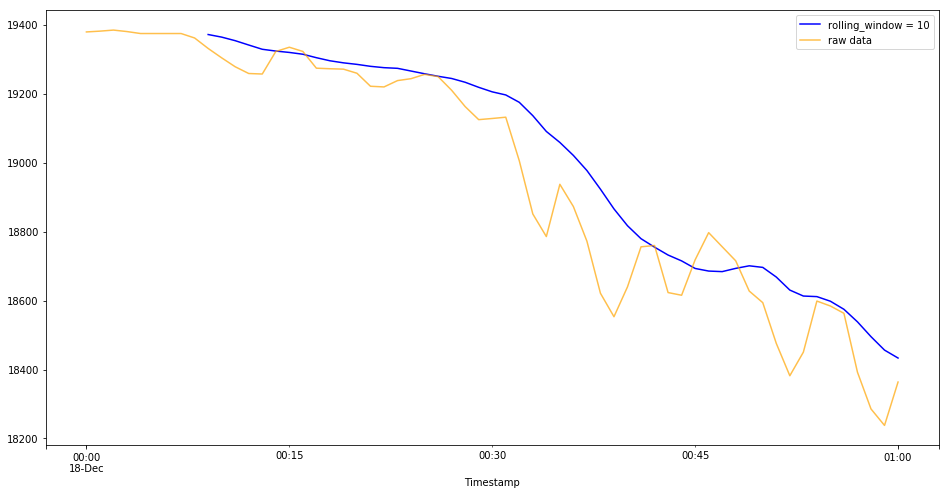

In [9]:
# Rolling windows:

# this is just the raw data, so we can apply a rolling window on it  
first_hour = data.loc['Dec 18th 2017 00:00:00':'Dec 18th 2017 01:00:00', 'Weighted_Price']

# notice the window size as a parameter of rolling, feel free to mess around with that parameter 
# and the center set to False. That's because we don't want to use data from the future! 
# Also notice how we use the mean. We can use many others. Try changing it! 
window_size = 10 
first_hour_rolling_window = first_hour.rolling(window=window_size, center=False).mean()

# Let's plot these together 
first_hour_rolling_window.plot(figsize=(16, 8), color='b', label='rolling_window = %0.0f' % window_size);
first_hour.plot(figsize=(16, 8), label='raw data', alpha=.7, ls='-', color='orange');
plt.legend();

### Handling multindex time series



#### Creating the multindex

In [10]:
data = pd.read_csv('data_for_notes/stocks.csv')
data.head()

,Date,Stock,Open,High,Low,Close,Volume
0,2007-01-03,nhc,46.2710,46.4810,45.5640,46.2710,26244
1,2007-01-03,vhi,3.0205,3.0205,2.8661,2.9215,94069
2,2007-01-03,bpt,37.5560,37.5560,37.0750,37.1820,489258
3,2007-01-03,cet,12.4790,12.4960,12.4060,12.4250,36413
4,2007-01-03,lndc,10.7000,11.3700,10.5000,11.3400,245349


In [11]:
data.Date = pd.to_datetime(data.Date) # convert to datetime
data = data.set_index(['Date', 'Stock']) # create a multindex dataset like this - order matters
data = data.sort_index() #always sort the index!
data.head()

Open      High       Low     Close   Volume
Date       Stock                                                 
2007-01-03 aap      35.139    35.621    34.527    35.011   776642
           abb      13.422    13.429    13.105    13.192  4030670
           achn     16.430    17.280    16.060    17.280    55226
           achv   1227.600  1231.560  1158.300  1191.960      785
           adm      27.457    27.864    27.065    27.269  8670704

#### Creating and using a IndexSlice object for selection

In [12]:
# To make selections in a multindex dataframe create first a IndexSlice object
idx = pd.IndexSlice 

In [13]:
# All dates just msft stock
data.loc[idx[:, 'msft'], :].head()

,,Open,High,Low,Close,Volume
Date,Stock,,,,,
2007-01-03,msft,25.073,25.367,24.655,25.041,91732862
2007-01-04,msft,24.898,25.132,24.688,24.998,54581739
2007-01-05,msft,24.832,24.948,24.697,24.856,53189559
2007-01-08,msft,24.864,25.242,24.764,25.099,59801289
2007-01-09,msft,25.141,25.308,24.930,25.123,53215396


In [14]:
#All stocks since 20th May 2009
data.loc[idx['May 20th, 2009', :], :].head(10)

Open     High      Low    Close   Volume
Date       Stock                                             
2009-05-20 aap     43.258   43.327   41.790   42.203  3000018
           abb     12.090   12.344   12.051   12.076  5429434
           achn     1.530    1.530    1.400    1.460    20597
           achv   154.990  157.960  141.130  151.800    34405
           adm     22.098   22.949   22.021   22.557  9876717
           adsk    19.480   19.880   19.000   19.140  3886829
           ae      14.057   14.057   13.561   13.854     5924
           aehr     1.010    1.040    1.000    1.010    81591
           aeo     10.449   10.991   10.177   10.228  6613587
           aezs   804.000  828.000  798.000  798.000       44

In [15]:
# All dates in range plus just the selected stocks and just close column
data.loc[idx['June 10th, 2008':'June 14th, 2008', ['msft', 'ibm' ,'ebay']], 'Close'].head()

Date        Stock
2008-06-10  ebay      12.197
            ibm      105.170
            msft      23.389
2008-06-11  ebay      11.667
            ibm      102.920
Name: Close, dtype: float64

#### Using Boolean masks with multindex

In [16]:
# Using a boolean mask with multindex:
#get index from data, use method get_level_values(0) to select the first level of index (date), 
#then use datetime atribute weekday_name to check for Mondays - returns boolean array
is_monday = data.index.get_level_values(0).weekday_name == 'Monday'
#then use as usual - in this case to to check the mean price on Mondays:
mondays_data = data.loc[is_monday].Close.mean()


In [17]:
#Using a more complex mask together with index:
from datetime import datetime #Python core library

start_date = datetime.strptime('10/06/2008', '%d/%m/%Y') #European format
end_date = datetime.strptime('14/06/2008', '%d/%m/%Y')  #European format

# Mask that selects dates between start and end date - notice you can also use the name of the level in get_level_values()
mask = ((start_date < data.index.get_level_values('Date')) & 
        (data.index.get_level_values('Date') < end_date))

#Using the idx with mask to select dates and list of stocks for second level - also only getting the Close column
data.loc[idx[mask, ['msft', 'ibm' ,'ebay']], 'Close']

Date        Stock
2008-06-11  ebay      11.667
            ibm      102.920
            msft      22.744
2008-06-12  ebay      11.818
            ibm      103.420
            msft      23.682
2008-06-13  ebay      11.944
            ibm      105.350
            msft      24.377
Name: Close, dtype: float64

#### Using unstack

In [18]:
# Unstack can be used when selecting just one column in a multindex to create a dataframe with the first index as rows and 
# the second as columns

data.loc[idx['June 10th, 2008':'June 14th, 2008', ['msft', 'ibm' ,'ebay']],'Close'].unstack()

Stock,ebay,ibm,msft
Date,,,
2008-06-10,12.197,105.17,23.389
2008-06-11,11.667,102.92,22.744
2008-06-12,11.818,103.42,23.682
2008-06-13,11.944,105.35,24.377


#### Creating cross sections (xs) for ploting graphs

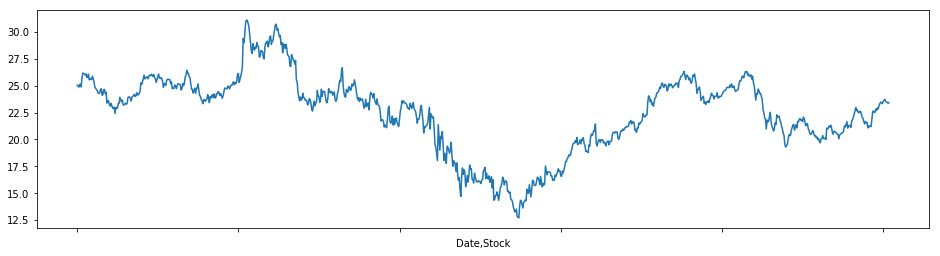

In [19]:
# Ploting graphs in multindex Series can create with the X axis presenting both levels even if this is not desirable ex:
data.loc[idx[:, 'msft'], 'Close'].plot(figsize=(16, 4)); #plotting close price for microsoft

For this case we should use cross sections [`xs`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.xs.html): 

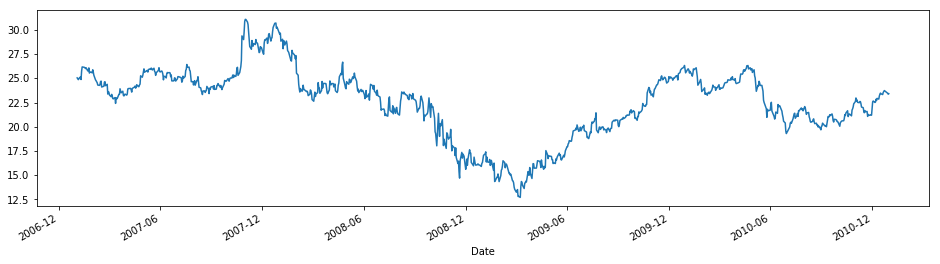

In [20]:
# Arguments are: what you want to select, from which level and the drop_level=True 
# gets rid of the stock level so the plot only has date in the x axis

data.xs('msft', level='Stock', drop_level=True).Close.plot(figsize=(16, 4));

#### Using GroupBy

In [21]:
#If you want to get for instance the percentage point change from day to day on a multindex
#you have to do a groupby Stock first otherwise you can get transitions from one stock to another 
#(pct_change will happily calculate allong the rows of the dataset)

data.groupby(level='Stock').Close.pct_change().loc['May 5th 2008'].head()

Date        Stock
2008-05-05  aap     -0.018962
            abb      0.004548
            achn     0.045946
            achv     0.020468
            adm      0.003425
Name: Close, dtype: float64

In [22]:
# checking the historic minimum close price for each stock
data.groupby(level='Stock').Close.min().head()

Stock
aap     23.7810
abb      6.8613
achn     0.6800
achv    24.3100
adm     13.0060
Name: Close, dtype: float64

In [23]:
# getting the date when the minimum first occured - using idxmin() 
data.groupby(level='Stock').Close.idxmin().head()

Stock
aap      (2008-10-27 00:00:00, aap)
abb      (2008-11-20 00:00:00, abb)
achn    (2008-12-31 00:00:00, achn)
achv    (2008-10-09 00:00:00, achv)
adm      (2008-10-09 00:00:00, adm)
Name: Close, dtype: object

In [24]:
# idxmin() returns index object and can be use directly to get entry

index_where_close_is_min = data.groupby(level='Stock').Close.idxmin().head()
data.loc[index_where_close_is_min, ['Open', 'Close', 'Volume'] ].head()

Open    Close    Volume
Date       Stock                            
2008-10-27 aap    24.8760  23.7810   1915606
2008-11-20 abb     7.2259   6.8613  11207124
2008-12-31 achn    0.8800   0.6800    217751
2008-10-09 achv   32.1200  24.3100       104
           adm    14.7400  13.0060  12407012

In [25]:
# can use agg() to use several aggregation functions
data.groupby(level='Stock').Close.agg(['min', 'max', 'mean','std', 'idxmin']).head()

,min,max,mean,std,idxmin
Stock,,,,,
aap,23.7810,67.439,40.619897,8.464828,"(2008-10-27 00:00:00, aap)"
abb,6.8613,24.403,15.568537,3.611735,"(2008-11-20 00:00:00, abb)"
achn,0.6800,19.610,3.603913,2.873874,"(2008-12-31 00:00:00, achn)"
achv,24.3100,1213.740,308.216941,354.840006,"(2008-10-09 00:00:00, achv)"
adm,13.0060,40.980,26.889387,5.015621,"(2008-10-09 00:00:00, adm)"


## Preparing TimeSeries for models and more thorough observation

### Observing and decomposing timeseries components

Time series are normaly composed of trend, cyclical, seasonal and irregular components

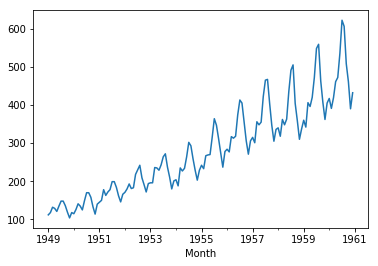

In [26]:
def load_airlines_series():
    airlines = pd.read_csv('data_for_notes/international-airline-passengers.csv')[:-1]
    airlines.Month = pd.to_datetime(airlines.Month)
    airlines = airlines.set_index('Month')
    airlines.columns = ['thousands of passengers']
    airlines = airlines['thousands of passengers']
    return airlines

data = load_airlines_series()
data.plot();

The trend can be visualized either as a linear regression:

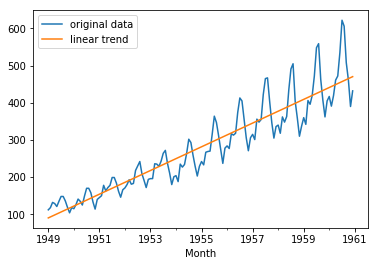

In [27]:
from sklearn.linear_model import LinearRegression

X = data.reset_index().index.values.reshape(-1, 1) 

slr = LinearRegression(fit_intercept=True)

slr.fit(X, data)

linear_trend = pd.Series(slr.predict(X), index=data.index)

data.plot(label="original data")
linear_trend.plot(label="linear trend")
plt.legend();

or as a rolling window. the bigger the averaging interval the smoother the curve

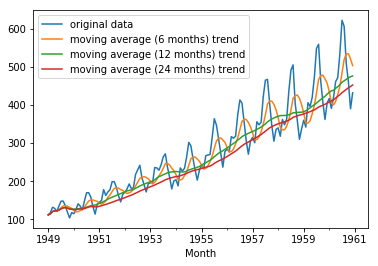

In [28]:
 # min periods will copy the data from the first points, otherwise the first 6/12 or 24 periods would be empty
 #- this is ok for visualization but not for calculations

moving_avg_6_months_ = data.rolling(6, min_periods=0).mean()
moving_avg_12_months_ = data.rolling(12, min_periods=0).mean()
moving_avg_24_months_ = data.rolling(24, min_periods=0).mean()

data.plot(label="original data")
moving_avg_6_months_.plot(label="moving average (6 months) trend")
moving_avg_12_months_.plot(label="moving average (12 months) trend")
moving_avg_24_months_.plot(label="moving average (24 months) trend")
plt.legend();

A way to decompose a timeseries into its components is using the seasonal_decompose function in statsmodels. Since a the time series components can be combined in an additive or multiplicative fashion the parameter model has to be passed to the function. Acording to [Hyndman & Athanasopoulos](https://otexts.org/fpp2/components.html)

> _The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series._

There are several ways to implement this: using [moving averages](https://otexts.org/fpp2/classical-decomposition.html), [X11](https://otexts.org/fpp2/x11.html), [SEATS](https://otexts.org/fpp2/seats.html) and [STL](https://otexts.org/fpp2/stl.html). We will use the moving averages approach that was implemented in [statsmodel](https://www.statsmodels.org/stable/index.html), a python module with a rich set of plots, models and validation procedures for time series.

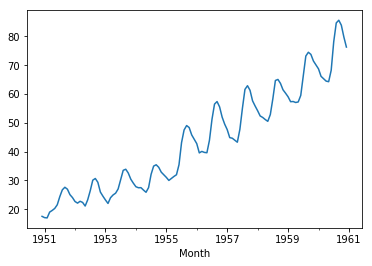

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

data.rolling(24).std().plot();

In this case the std increases with time so it is a good indication that a multiplicative decomposition should be used.

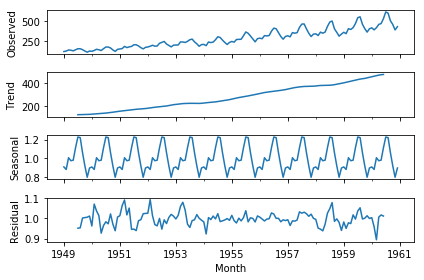

In [30]:
decomposition = seasonal_decompose(data, model='multiplicative')
decomposition.plot()
plt.show()

In [31]:
# You can access any specific component in the decomposition object like this:

decomposition.trend.head(10)

# also can use seasonal and resid

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
Name: thousands of passengers, dtype: float64

### Checking autocorrelation

#### Lag plots

You can check correlation of the current time period with previous time periods using lag plots

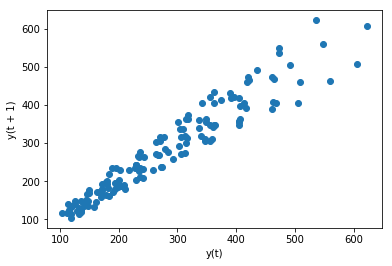

In [32]:
from pandas.plotting import lag_plot

lag_plot(data, lag=1); #correlation with the previous time period

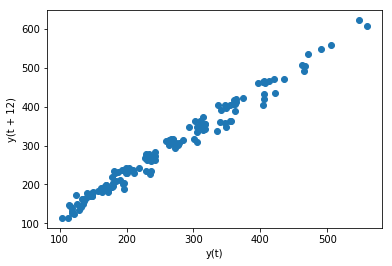

In [33]:
lag_plot(data, lag=12); # correlation with 12 periods behind (since data is monthly here we are correlating the same months)

#### Autocorrelation function and plots

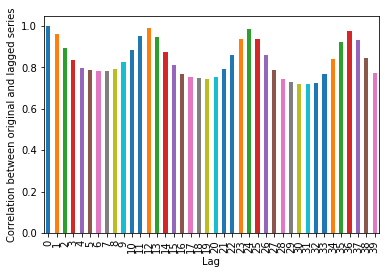

In [34]:
# doing it by hand

corrs = {}
for lag in range(40):
    corrs[lag] = data.corr(data.shift(lag))
    
pd.Series(corrs).plot(kind='bar')
plt.xlabel('Lag')
plt.ylabel('Correlation between original and lagged series')
plt.show();

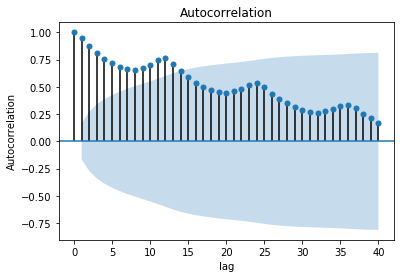

In [35]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

autocorr = acf(data)# gets the array for the correlations

plot_acf(data, alpha=.05, lags=40) #alpha for confidance interval, lags for maximum lags to show
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

#### Partial autocorrelation function and plot

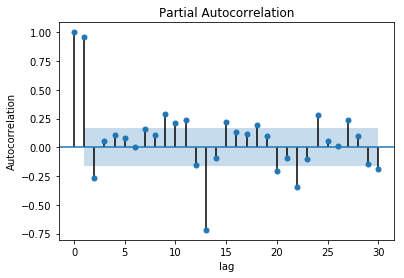

In [36]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data, alpha=.05, lags=30)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

### Transforming a TimeSeries to achieve stationarity

To use a time series it should be made stationary

#### Log Transform

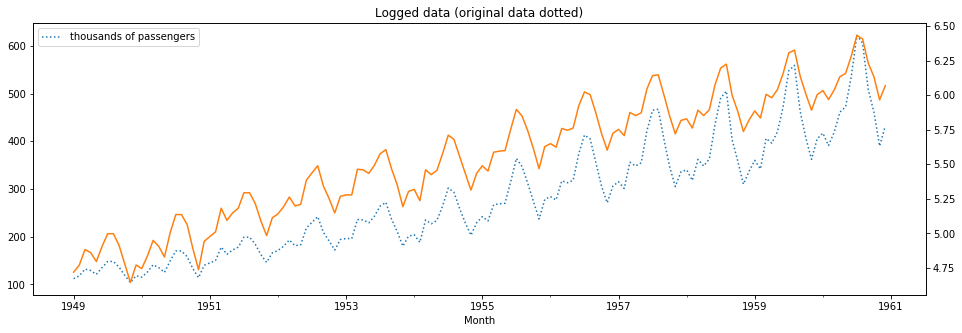

In [37]:
# A log transform should be performed if the variance is increasing. It's the easiest wat to achieve constant variance.

data_log = data.map(np.log)
data.plot(legend='Original', ls=':')
data_log.plot(figsize=(16, 5), secondary_y=True)
plt.title('Logged data (original data dotted)')
plt.show()

#### Applying diff()

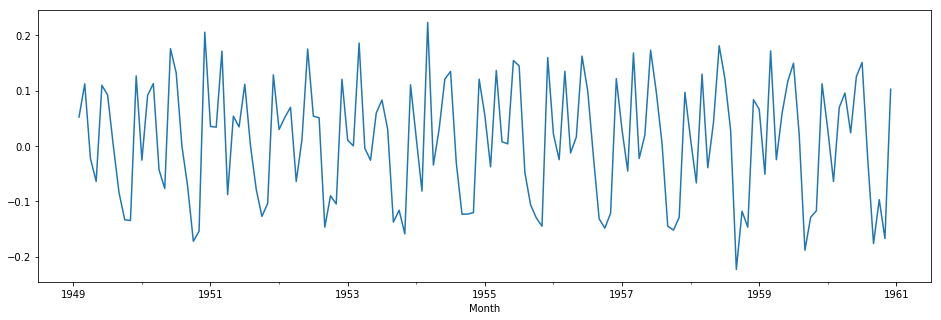

In [38]:
# To remove the trend the easiest way is to apply a diference - this should be done after aplying the log since it can create
# 0 entries

data_log_diff = data_log.diff(periods=1)
data_log_diff.plot(figsize=(16, 5));

#### Evaluating stationarity

For that, we use the **[Dickey-Fuller test](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller)**. The Dickey-Fuller test has the null hypothesis that the Unit Root is present. The details of this are interesting yet out of scope, but suffice it to say for our purposes that if the unit root isn't present, the timeseries can be assumed to be stationary.

So, for the time being, "Unit Root is bad", and "no Unit Root is good". If the pvalue is above a critical size, then we cannot reject that there is a unit root. We want a low p value. It's worth taking a look at [the documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller)

In [39]:
from statsmodels.tsa.stattools import adfuller

#Wrap test in try except block in case it does not converge - drop missing data as well
try: 
    adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data_log_diff.dropna())
except Exception as e:
    print('NEIN! And here is why: %s' % e)
    
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -2.72
pvalue:    0.071


Since p-value is above 0.05 we cannot reject the null hipotesis at a 95% confidence interval. A way to achieve stationarity is to take another difference

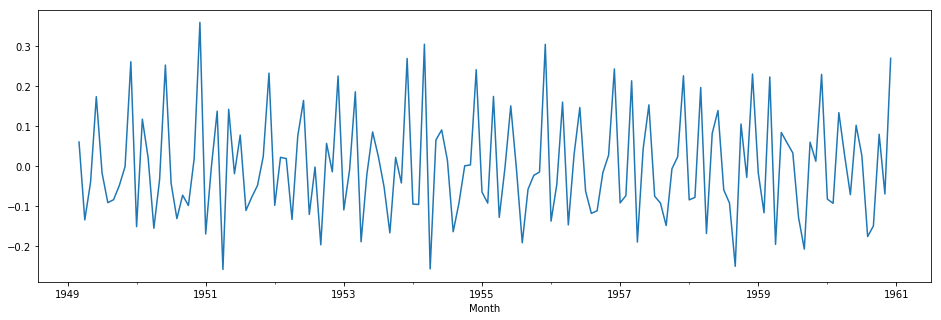

In [40]:
data_logged_and_diffed_twice = data_log_diff.diff() # taking a second diff 

data_logged_and_diffed_twice.plot(figsize=(16, 5));

In [41]:
try: 
    adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data_logged_and_diffed_twice.dropna())
except Exception as e:
    print('NEIN! And here is why: %s' % e)
    
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -8.20
pvalue:    0.000


#### Reversing transformations

In [42]:
#Use cumsum to reverse diff

def rebuild_diffed(_series, _original_series):
    
    # get the cumulative sum
    cumsum = _series.cumsum()
    
    # fill the most recent zero 
    # (in our case there was just one, but this way it works beyond it)
    most_recent_null = cumsum.loc[cumsum.isnull()].index.max()
    cumsum.loc[most_recent_null] = 0 
    
    # return the cumsum, plus the first original element
    return cumsum + _original_series.iloc[0]

# To reverse one diff apply the function
rebuilt_data = rebuild_diffed(data_log_diff, data_log)

# To reverse two diff apply the function twice
# dropna() here! if not it will pick the NA as first element
rebuild_half_1 = rebuild_diffed(data_logged_and_diffed_twice, data_log_diff.dropna()) 
rebuilt_data_2 = rebuild_diffed(rebuild_half_1, data_log) 

(rebuilt_data_2 == data_log).head()

Month
1949-01-01    True
1949-02-01    True
1949-03-01    True
1949-04-01    True
1949-05-01    True
Name: thousands of passengers, dtype: bool

In [43]:
# Use np.exp to reverse the log in the end

original_rebuilt = rebuilt_data_2.map(np.exp)

np.isclose(original_rebuilt, data)[0:6]

array([ True,  True,  True,  True,  True,  True])

In [44]:
#Usefull custom functions:

def rebuild_diffed(_series, _original_series):
    
    # get the cumulative sum
    cumsum = _series.cumsum()
    
    # fill the most recent zero 
    # (in our case there was just one, but this way it works beyond it)
    most_recent_null = cumsum.loc[cumsum.isnull()].index.max()
    cumsum.loc[most_recent_null] = 0 
    
    # return the cumsum, plus the first original element
    return cumsum + _original_series.iloc[0]


def revert_1diff_and_log(_transf_series, _original_series_log):
    rebuild_logged = rebuild_diffed(_transf_series, _original_series_log)
    original_rebuilt = rebuild_logged.map(np.exp)
    return original_rebuilt


# function to revert 2 diffs and a log

def revert_2_diffs_and_log(_transf_series, _original_after_dif, _original_series_log):
    rebuild_half_1 = rebuild_diffed(_transf_series, _original_after_dif.dropna()) 
    rebuilt_data_2 = rebuild_diffed(rebuild_half_1, _original_series_log) 
    original_rebuilt = rebuilt_data_2.map(np.exp)
    return original_rebuilt
    

## Creating and fitting models

### ARIMA

ARIMA(p,d,q)

p, is the "number of auto-regressive terms" - use the partial autocorrelation plot. A rule of thumb is to start by testing the number of components where the significance line gets crossed, and make that our p

d relates to the integrated part of the ARIMA and is number of diffs required to make stationary - if passing an already diffed array tou can set it at 0

q is the "number of moving average terms". - use the autocorrelation plot. A rule of thumb is to start by testing the number of components where the significance line gets crossed, and make that our q. Note use the autocorrelation function for the transformed data!


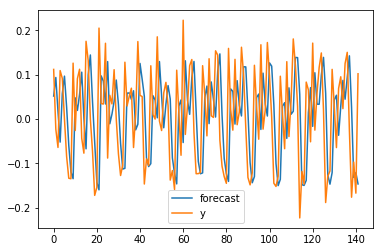

In [45]:
# Not going to use this but will just use SARIMAX instead
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data_log_diff.dropna().values, order=(1, 1, 0)) # have to pass it a numpy array
results = model.fit();
results.plot_predict()
plt.show()

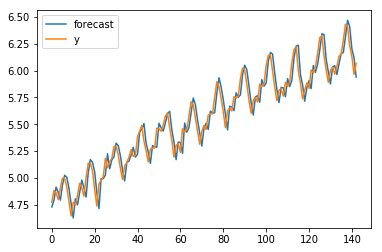

In [46]:
#using it on the just logged data but passing a d parameter

model2 = ARIMA(data_log.values, order=(1, 1, 0)) # have to pass it a numpy array
results2 = model2.fit();
results2.plot_predict()
plt.show()

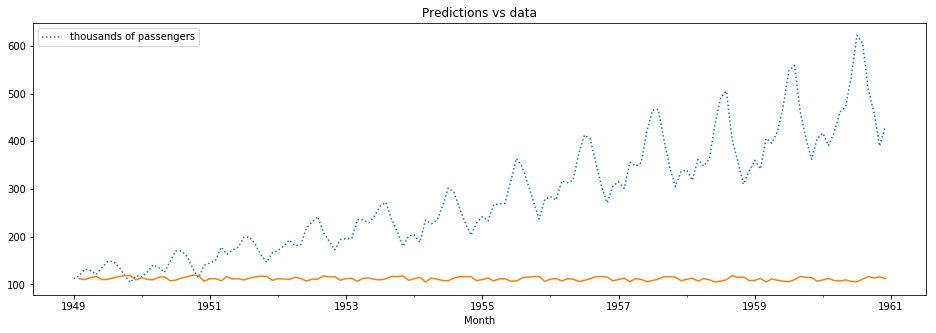

In [47]:
#getting predictions from model

predictions_transformed = pd.Series(results.predict())
predictions = revert_1diff_and_log(predictions_transformed, data_log)

predictions.index = data.index[1:]
predictions = predictions.dropna()

data.plot(legend='Original', ls=':')
predictions.plot(figsize=(16, 5))
plt.title('Predictions vs data')
plt.show()

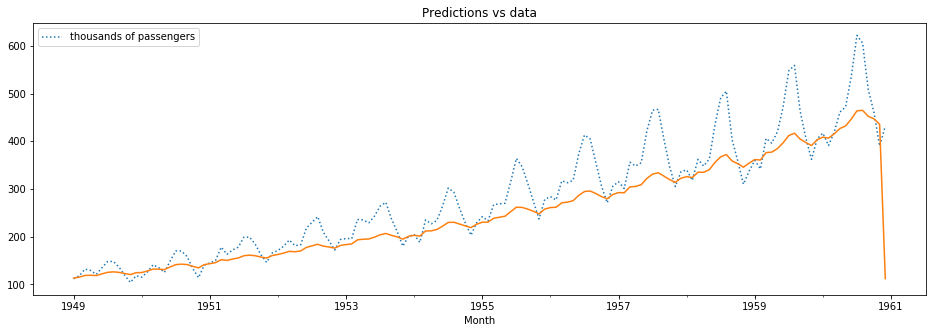

In [48]:
#getting predictions from model

predictions_transformed2 = pd.Series(results2.predict())
predictions2 = revert_1diff_and_log(predictions_transformed2, data_log)

predictions2.index = data.index
predictions2 = predictions2.dropna()

data.plot(legend='Original', ls=':')
predictions2.plot(figsize=(16, 5))
plt.title('Predictions vs data')
plt.show()

### SARIMAX

#### Simple call to method and plotting results

In [49]:
model = sm.tsa.statespace.SARIMAX(data,             # <-- holy crap just passed it pandas? No ".values"? No .diff?
                          order=(0, 1, 1),              # <-- keeping our order as before in BLU2 
                          seasonal_order=(1, 1, 1, 12)) # <-- We'll get into how we found these hyper params later 

results = model.fit()



In [50]:
pred = results.get_prediction(start=data.index.min(),  # <--- Start at the first point we have 
                              dynamic=False)               # <--- Dynamic means "use only the data 
                                                           #      from the past, we'll use this eventually 

In [94]:
def plot_predictions(series_, pred_, target_variable_name):
    
    
    mean_predictions_ = pred_.predicted_mean

    pred_ci_ = pred_.conf_int()
    
    series_.plot(label='observed')
    mean_predictions_.plot(label='predicted', 
                           alpha=.7)

    plt.fill_between(pred_ci_.index,
                     pred_ci_['lower ' + target_variable_name],
                     pred_ci_['upper ' + target_variable_name], 
                     color='k', 
                     alpha=.2)

    plt.ylim([-500, 50000])
    plt.legend()
    plt.show()
    
    
##plot_predictions(data, pred, 'passengers_thousands')

#### Grid search with joblib

In [52]:
from tqdm import tqdm_notebook # for a progress bar
import itertools #to make combinations 
from joblib import Parallel, delayed # parallel processing

In [53]:
#Example data setup cell

train = pd.read_csv('data_for_notes/train_stores.csv')
test = pd.read_csv('data_for_notes/test_stores.csv')

train.Date = pd.to_datetime(train.Date, format='%Y-%m-%d')
train = train.set_index(['Date', 'Store'])
train = train.sort_index()

test.Date = pd.to_datetime(test.Date, format='%Y-%m-%d')
test = test.set_index(['Date', 'Store'])
test = test.sort_index()

idx = pd.IndexSlice
store_1 = train.loc[idx[:, 1], :]

#interesting group_by to get mean sales per weekday
store_1.groupby(store_1.index.get_level_values('Date').weekday_name).Sales.mean() 


#Getting a series with just the Sales component
a_store = train.loc[idx[:, 7], 'Sales']
# remove the level of the index that just says "4, 4, 4, 4 ..." because it's always the same store
a_store.index = a_store.index.droplevel('Store')

In [54]:
days_in_test = test.index.get_level_values('Date').unique()
sorted(days_in_test)

[Timestamp('2015-07-28 00:00:00'),
 Timestamp('2015-07-29 00:00:00'),
 Timestamp('2015-07-30 00:00:00'),
 Timestamp('2015-07-31 00:00:00')]

In [55]:
def get_param_inputs(max_range, seasonality):
    p = d = q = P = D = Q = range(0, max_range)
    S = seasonality
    params_combinations = list(itertools.product(p, d, q, P, D, Q))
    inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], S] for x in params_combinations]
    return inputs

def get_aic(series_, params):
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    try:
        model = sm.tsa.statespace.SARIMAX(series_,
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, S),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        results = model.fit()
        
    except:
        return 1000000000
    
    return results.aic


def get_best_params(series_, inputs):
    
    aic_scores = {}
    params_index = {}
    for i in tqdm_notebook(range(len(inputs))):
        try: 
            param_set = inputs[i]
            aic = get_aic(series_, param_set) 
            aic_scores[i] = aic
            params_index[i] = param_set

        except Exception as e: 
            continue

    temp = pd.DataFrame(params_index).T
    temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
    temp['aic'] = pd.Series(aic_scores)
    temp.sort_values('aic').head()

    best_model_params = temp.aic.idxmin()

    return temp.loc[best_model_params]

In [56]:
#slow dont use
'''
%%time 
inputs = get_param_inputs(3, 7)
best_params = get_best_params(a_store, inputs)
print(best_params)
'''

'\n%%time \ninputs = get_param_inputs(3, 7)\nbest_params = get_best_params(a_store, inputs)\nprint(best_params)\n'

In [57]:
# making it with joblib

def wrap_get_aic(_series, _params): 
        return (_params, get_aic(_series, _params))

def get_best_params_parallel(series_, inputs, wrapper_function):
    
    res = Parallel(n_jobs=-1)(delayed(wrapper_function)(_series=series_, _params=param) for param in tqdm_notebook(inputs))

    temp = pd.DataFrame(res)
    temp.columns = ["params", "aic"]
    temp = temp.set_index("params", drop=True)
    best_params = temp.aic.idxmin()
    best_aic = temp.aic.min()
    order = best_params[:3]
    seasonal_order = best_params[3:]
    seasonal_order
    
    return best_aic, order, seasonal_order


In [58]:
# only uncomment if you want to run again - it works but takes aprox 15 mins - best parameters are recorded below
'''
%%time 
inputs = get_param_inputs(3, 7)
best_aic, order, seasonal_order = get_best_params_parallel(a_store, inputs, wrap_get_aic)
print(best_aic)
print(order)
print(seasonal_order)
'''

'\n%%time \ninputs = get_param_inputs(3, 7)\nbest_aic, order, seasonal_order = get_best_params_parallel(a_store, inputs, wrap_get_aic)\nprint(best_aic)\nprint(order)\nprint(seasonal_order)\n'

In [59]:
# best parameters so i don't have to run previous cell

order = [1, 0, 2]
seasonal_order = [1, 2, 2, 7]

#### Fitting model to several timeseries with optimal params and joblib

In [60]:
# For problems with two levels - adapted from learning note book but generalized and made to work with joblib
#returns first a model dictionary and then uses separate function for forecasts

from joblib import Parallel, delayed

def predict_with_sarimax(df_, second_idx_num, second_idx_name, target_variable_name, order, seasonal_order): 
    
    df_subset_ = df_.loc[idx[:, second_idx_num], target_variable_name]
    
    df_subset_.index = df_subset_.index.droplevel(second_idx_name)

    model = sm.tsa.statespace.SARIMAX(df_subset_,             
                              order=order,             
                              seasonal_order=seasonal_order,
                              enforce_stationarity=False,  
                              enforce_invertibility=False) 

    results = model.fit()
    del(model)
    return results


def wrap_predict_with_sarimax(df_, second_idx_num, second_idx_name, target_variable_name, order, seasonal_order): 
    return (second_idx_num, predict_with_sarimax(df_, second_idx_num, second_idx_name, 
                                                 target_variable_name, order, seasonal_order))


def predict_all_with_sarimax_parallel(df_, second_idx_name, target_variable_name, 
                                      order, seasonal_order, second_idx_list, wrapper_function):
    
    res = Parallel(n_jobs=-1)(delayed(wrapper_function)(df_=df_,
                                                        second_idx_num=second_idx_num, 
                                                        second_idx_name=second_idx_name,
                                                        target_variable_name=target_variable_name,
                                                        order=order, 
                                                        seasonal_order=seasonal_order) 
                          for second_idx_num in tqdm_notebook(second_idx_list))

    res = dict(res)
    

    return res


def get_forecasts_from_model_dict(model_dict, n_steps, second_idx_name, target_variable_name):
    
    forecasts = {}
    
    for index, model in model_dict.items():
        forecasts[index] = model.get_forecast(steps=n_steps).predicted_mean
    
    results = pd.DataFrame(forecasts).unstack().reset_index()
    results.columns = [second_idx_name, 'Date', target_variable_name]
    results = results.set_index(['Date', second_idx_name]).sort_index()
    
    return results
        
    
    

In [61]:
# only uncomment to run again - use pickle file instead in next cell
'''
%%time 
# This is another cell that will take a long time to run. 
stores_list = train.index.get_level_values('Store').unique()


model_dict_1 = predict_all_with_sarimax_parallel(train, 'Store', 'Sales', order, seasonal_order, 
                                         stores_list, wrap_predict_with_sarimax)

# making pickle to store model dict so you dont have to run it again!

pickle_out = open('model_dict_1.pickle', "wb")
pickle.dump(model_dict_1, pickle_out)
pickle_out.close()

'''

'\n%%time \n# This is another cell that will take a long time to run. \nstores_list = train.index.get_level_values(\'Store\').unique()\n\n\nmodel_dict_1 = predict_all_with_sarimax_parallel(train, \'Store\', \'Sales\', order, seasonal_order, \n                                         stores_list, wrap_predict_with_sarimax)\n\n# making pickle to store model dict so you dont have to run it again!\n\npickle_out = open(\'model_dict_1.pickle\', "wb")\npickle.dump(model_dict_1, pickle_out)\npickle_out.close()\n\n'

In [62]:
# opening pickle file

try:
    pickle_in = open('model_dict_1.pickle', "rb")
    model_dict_1 = pickle.load(pickle_in)
    pickle_in.close()
except:
    print("No file found")
    
    
pred_res = get_forecasts_from_model_dict(model_dict_1, 10, "Store", 'Sales')

In [63]:
pred_res.head(6)

Sales
Date       Store              
2015-07-28 1       4572.090095
           2       6160.908682
           3       8755.970034
           4      10996.154500
           5       6026.050298
           6       5717.836938

In [64]:
def insert_predictions_in_test(test_df_, predictions_df_, target_variable_name):
    
    new_test = test_df_.copy()
    days_in_test_set = test_df_.index.get_level_values('Date').unique()
    for day in days_in_test_set:
        new_test.loc[idx[day, :], 'predictions'] = predictions_df_.loc[idx[day, :], target_variable_name].values
    return new_test
    

In [65]:
test_with_pred = insert_predictions_in_test(test, pred_res, 'Sales')
test_with_pred.head()

Customers  Open   predictions
Date       Store                               
2015-07-28 1            560     1   4572.090095
           2            646     1   6160.908682
           3            818     1   8755.970034
           4           1191     1  10996.154500
           5            598     1   6026.050298

In [90]:
def plot_predictions(series_, pred_, target_variable_name):
    
    
    mean_predictions_ = pred_.predicted_mean

    pred_ci_ = pred_.conf_int()
    
    series_.plot(label='observed', figsize=(16, 6))
    mean_predictions_.plot(label='predicted', 
                           alpha=.7)

    plt.fill_between(pred_ci_.index,
                     pred_ci_['lower ' + target_variable_name],
                     pred_ci_['upper ' + target_variable_name], 
                     color='k', 
                     alpha=.2)

    
    plt.legend()
    plt.show()

In [89]:

model_for_store1 = model_dict_1[1]

sales_store_1 = train.loc[idx[:, 1], 'Sales']
sales_store_1.index = sales_store_1.index.droplevel('Store')

predictions_store_1 = model_for_store1.get_prediction(start=sales_store_1.index.min(), dynamic=False)

plot_predictions(sales_store_1, predictions_store_1,  'Sales')

KeyError: 'the label [Sales] is not in the [columns]'

#### Adding exogenous variable to the model

In [67]:
# New data using store data with lots of exogenous variables - just using the train and spliting the final days as test

data = pd.read_csv('data_for_notes/train_stores_comp.csv')

data.date = pd.to_datetime(data.date, format='%Y-%m-%d')
data = data.rename(columns={'date': 'Date'})
data = data.set_index(['Date', 'store', 'section'])
data = data.sort_index()
data.head()

#this is actualy a 3 level dataset but to simplify just to test the function we will check only section 1 of each store

store_type  store_size  temperature  fuel_prc  consumer_prc_idx  unemployment_rate  environment_ratio_1  environment_ratio_2  time_agg_env_ratio  time_agg_grp_2  time_agg_grp_1     sales
Date       store section                                                                                                                                                                                           
2010-02-05 1     1                A      151315        42.31     2.572        211.096358              8.106             4.038806             1.685111            7.262324               2               2  24924.50
                 2                A      151315        42.31     2.572        211.096358              8.106             3.974635             1.468157            7.361343               2               2  50605.27
                 3                A      151315        42.31     2.572        211.096358              8.106             3.972735             1.507818            7.704185               2               2  13740.12
                 4                A      151315        42.31     2.572        211.096358              8.106             4.056106             1.464406            7.530632               2               2  39954.04
                 5                A      151315        42.31     2.572        211.096358              8.106             3.986196             1.671115            7.472874               2               2  32229.38

In [68]:
data = data.loc[idx[:,:,1],:]
data.index = data.index.droplevel('section')
data.head()

store_type  store_size  temperature  fuel_prc  consumer_prc_idx  unemployment_rate  environment_ratio_1  environment_ratio_2  time_agg_env_ratio  time_agg_grp_2  time_agg_grp_1     sales
Date       store                                                                                                                                                                                           
2010-02-05 1              A      151315        42.31     2.572        211.096358              8.106             4.038806             1.685111            7.262324               2               2  24924.50
           2              A      202307        40.19     2.572        210.752605              8.324             3.986512             1.667294            7.476588               2               2  35034.06
           3              B       37392        45.71     2.572        214.424881              7.368             4.099912             1.662846            7.061101               2               2   6453.58
           4              A      205863        43.76     2.598        126.442065              8.623             3.995161             1.498924            7.664058              17               0  38724.42
           5              B       34875        39.70     2.572        211.653972              6.566             3.929541             1.597001            6.581492               2               2   9323.89

In [69]:
# Using a function to make plots of the sales vs other time series

#selecting store 1 and dropping store index

store_1 = data.loc[idx[:,1],:]
store_1.index = store_1.index.droplevel('store')
store_1 = store_1.drop('store_type', axis=1)


from itertools import product

#not working yet!
def make_plots_of_target_vs_other_with_other_axis(df_, target_name):
    for target, other in product([target_name], df_.drop(target_name, axis=1).columns): 
        plt.figure(figsize=(16, 6));
        df_[[target]].plot(label=target);
        df_[[other]].plot(label=other, secondary_y=True);
        plt.show();


#make_plots_of_target_vs_other_with_other_axis(store_1, 'sales')

In [70]:
# check dataset for missing values

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6435 entries, (2010-02-05 00:00:00, 1) to (2012-10-26 00:00:00, 45)
Data columns (total 12 columns):
store_type             6435 non-null object
store_size             6435 non-null int64
temperature            6435 non-null float64
fuel_prc               6435 non-null float64
consumer_prc_idx       6435 non-null float64
unemployment_rate      6435 non-null float64
environment_ratio_1    6434 non-null float64
environment_ratio_2    6434 non-null float64
time_agg_env_ratio     6435 non-null float64
time_agg_grp_2         6435 non-null int64
time_agg_grp_1         6435 non-null int64
sales                  6435 non-null float64
dtypes: float64(8), int64(3), object(1)
memory usage: 625.0+ KB


In [71]:
#missing values in environment ratio -  using interpolation to replace - just one value

data['environment_ratio_1'] = data['environment_ratio_1'].interpolate()
data['environment_ratio_2'] = data['environment_ratio_2'].interpolate()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6435 entries, (2010-02-05 00:00:00, 1) to (2012-10-26 00:00:00, 45)
Data columns (total 12 columns):
store_type             6435 non-null object
store_size             6435 non-null int64
temperature            6435 non-null float64
fuel_prc               6435 non-null float64
consumer_prc_idx       6435 non-null float64
unemployment_rate      6435 non-null float64
environment_ratio_1    6435 non-null float64
environment_ratio_2    6435 non-null float64
time_agg_env_ratio     6435 non-null float64
time_agg_grp_2         6435 non-null int64
time_agg_grp_1         6435 non-null int64
sales                  6435 non-null float64
dtypes: float64(8), int64(3), object(1)
memory usage: 625.0+ KB


In [72]:
# slow so only uncomment if you really want to re-run it - works but takes 20 mins - optimal parameters it found are below
'''
store_1_sales = store_1.loc[:, 'sales'] #carefull pass it a series not a dataframe with lots of columns!
inputs = get_param_inputs(3, 52)
best_aic, order, seasonal_order = get_best_params_parallel(store_1_sales, inputs, wrap_get_aic)
print(best_aic)
print(order)
print(seasonal_order)
'''

"\nstore_1_sales = store_1.loc[:, 'sales'] #carefull pass it a series not a dataframe with lots of columns!\ninputs = get_param_inputs(3, 52)\nbest_aic, order, seasonal_order = get_best_params_parallel(store_1_sales, inputs, wrap_get_aic)\nprint(best_aic)\nprint(order)\nprint(seasonal_order)\n"

In [73]:
# saving best parameters so i dont have to run the cell above again
order = [2, 2, 1]
seasonal_order = [1, 1, 0, 52]

In [83]:
from joblib import Parallel, delayed

def predict_with_sarimax_exo(train_df_, second_idx_num, second_idx_name, target_variable_name, 
                             order, seasonal_order, exo_variables_name_list=[]): 
    
    endo_train_subset_ = train_df_.loc[idx[:, second_idx_num], target_variable_name]
    exo_train_subset_ = train_df_.loc[idx[:, second_idx_num], exo_variables_name_list]
    
    endo_train_subset_.index = endo_train_subset_.index.droplevel(second_idx_name)
    exo_train_subset_.index = exo_train_subset_.index.droplevel(second_idx_name)

    model = sm.tsa.statespace.SARIMAX(endo_train_subset_,
                              exog=exo_train_subset_,      
                              order=order,             
                              seasonal_order=seasonal_order,
                              enforce_stationarity=False,  
                              enforce_invertibility=False) 
    

    results = model.fit()
    return results


def wrap_predict_with_sarimax_exo(train_df_, second_idx_num, second_idx_name, 
                                  target_variable_name,  order, seasonal_order, exo_variables_name_list): 
    
    return (second_idx_num, predict_with_sarimax_exo(train_df_, second_idx_num, second_idx_name, 
                                                     target_variable_name, order, seasonal_order,
                                                     exo_variables_name_list))


def predict_all_with_sarimax_exo_parallel(train_df_, second_idx_name, target_variable_name, 
                                          order, seasonal_order, exo_variables_name_list, 
                                          second_idx_list, wrapper_function):
    
    res = Parallel(n_jobs=-1)(delayed(wrapper_function)(train_df_=train_df_,
                                                        second_idx_num=second_idx_num,
                                                        second_idx_name=second_idx_name, 
                                                        target_variable_name=target_variable_name, 
                                                        order=order, 
                                                        seasonal_order=seasonal_order,
                                                        exo_variables_name_list=exo_variables_name_list)
                              for second_idx_num in tqdm_notebook(second_idx_list))

    res = dict(res)
    
    return res


def get_forecasts_from_model_dict_exo(model_dict, test_df_, n_steps, second_idx_name, 
                                      target_variable_name, exo_variables_name_list):
    
    forecasts = {}
    
    for index, model in model_dict.items():
        exo_test_subset = test_df_.loc[idx[:, index], exo_variables_name_list]
        forecasts[index] = model.get_forecast(steps=n_steps, exog=exo_test_subset).predicted_mean
    
    results = pd.DataFrame(forecasts).unstack().reset_index()
    results.columns = [second_idx_name, 'Date', target_variable_name]
    results = results.set_index(['Date', second_idx_name]).sort_index()
    
    return results


In [75]:
data.index.get_level_values('Date').max()

Timestamp('2012-10-26 00:00:00')

In [76]:
# spliting the data into train and test:

def split_train_test_x_days(_data, time_offset_in_days):
    last_day_in_index = _data.index.get_level_values('Date').max()

    new_last_day_train = last_day_in_index - pd.DateOffset(days=time_offset_in_days)
    new_first_day_test = last_day_in_index - pd.DateOffset(days=time_offset_in_days - 1)

    train = _data.loc[idx[:new_last_day_train, :], :]
    test = _data.loc[idx[new_first_day_test:, :], :]
    
    return train, test

#dataset is weekly so lets take 4 weeks off or 30 days
train, test = split_train_test_x_days(data, 30)
train.tail()

store_type  store_size  temperature  fuel_prc  consumer_prc_idx  unemployment_rate  environment_ratio_1  environment_ratio_2  time_agg_env_ratio  time_agg_grp_2  time_agg_grp_1         sales
Date       store                                                                                                                                                                                               
2012-09-21 41             A      196321        59.81     3.765        198.358523              6.432             3.173349             1.208773          155.585090              14               2  20839.985148
           42             C       39690        81.93     4.125        131.010333              7.170             3.153556             1.182569          164.800602              12               0  10299.965531
           43             C       41062        75.87     3.721        214.119233              9.285             3.330236             1.370119          186.489333              14               2   7138.284375
           44             C       39910        67.96     3.821        131.010333              5.407             3.169977             1.180993          141.223610              12               0   8791.861754
           45             B      118221        65.32     4.038        191.856704              8.684             3.059361             1.130586          180.552007               9               2  12329.754010

In [77]:
test.head()

store_type  store_size  temperature  fuel_prc  consumer_prc_idx  unemployment_rate  environment_ratio_1  environment_ratio_2  time_agg_env_ratio  time_agg_grp_2  time_agg_grp_1         sales
Date       store                                                                                                                                                                                               
2012-09-28 1              A      151315        76.08     3.666        222.981658              6.908             3.433992             1.334359          166.038721               6               2  17470.131027
           2              A      202307        79.45     3.666        222.616433              6.565             3.398203             1.258196          161.409561               6               2  23783.833877
           3              B       37392        77.46     3.666        226.518093              6.334             3.388050             1.244878          158.348088               6               2   8985.352622
           4              A      205863        71.74     3.666        131.043000              4.077             3.311777             1.320968          120.445213              12               0  36955.481259
           5              B       34875        78.33     3.666        223.574102              5.603             3.422812             1.209767          147.855746               6               2  10101.876994

In [78]:
days_in_test = test.index.get_level_values('Date').unique()
sorted(days_in_test)

[Timestamp('2012-09-28 00:00:00'),
 Timestamp('2012-10-05 00:00:00'),
 Timestamp('2012-10-12 00:00:00'),
 Timestamp('2012-10-19 00:00:00'),
 Timestamp('2012-10-26 00:00:00')]

In [79]:
exo_column_names = ['consumer_prc_idx']
stores_list = train.index.get_level_values('store').unique()


In [80]:
# takes loads of time - aprox 30-40 mins
model_dict_2 = predict_all_with_sarimax_exo_parallel(train, 'store', 'sales', 
                                          order, seasonal_order, exo_column_names, 
                                          stores_list, wrap_predict_with_sarimax_exo)


In [81]:
# making pickle to store model dict so you dont have to run it again! - cant make it kernel dies!
'''
try:
    pickle_out = open('model_dict_2.pickle', "wb")
    pickle.dump(model_dict_2, pickle_out)
    pickle_out.close()
except:
    pass

'''

'\ntry:\n    pickle_out = open(\'model_dict_2.pickle\', "wb")\n    pickle.dump(model_dict_2, pickle_out)\n    pickle_out.close()\nexcept:\n    pass\n\n'

In [84]:
# opening pickle file

try:
    pickle_in = open('model_dict_2.pickle', "rb")
    model_dict_2 = pickle.load(pickle_in)
    pickle_in.close()
except:
    print("No file found")
    
    
pred_results_2 = get_forecasts_from_model_dict_exo(model_dict_2, test, 5, "store", 'sales', exo_column_names)

No file found


In [85]:
test_with_pred = insert_predictions_in_test(test, pred_results_2, 'sales')

test_with_pred.head()

store_type  store_size  temperature  fuel_prc  consumer_prc_idx  unemployment_rate  environment_ratio_1  environment_ratio_2  time_agg_env_ratio  time_agg_grp_2  time_agg_grp_1         sales   predictions
Date       store                                                                                                                                                                                                             
2012-09-28 1              A      151315        76.08     3.666        222.981658              6.908             3.433992             1.334359          166.038721               6               2  17470.131027  18281.294263
           2              A      202307        79.45     3.666        222.616433              6.565             3.398203             1.258196          161.409561               6               2  23783.833877  29324.262997
           3              B       37392        77.46     3.666        226.518093              6.334             3.388050             1.244878          158.348088               6               2   8985.352622   9092.295985
           4              A      205863        71.74     3.666        131.043000              4.077             3.311777             1.320968          120.445213              12               0  36955.481259  34886.340760
           5              B       34875        78.33     3.666        223.574102              5.603             3.422812             1.209767          147.855746               6               2  10101.876994  10685.303414

In [86]:
store_1_preds = test_with_pred.loc[idx[:,1],:]


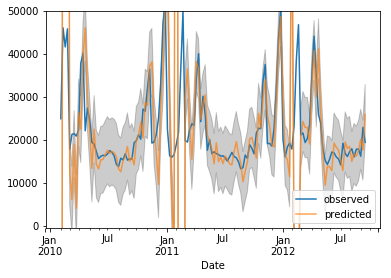

In [95]:
model_for_store1_exo = model_dict_2[1]

sales_store_1 = train.loc[idx[:, 1], 'sales']
sales_store_1.index = sales_store_1.index.droplevel('store')

predictions_store_1_exo = model_for_store1_exo.get_prediction(start=sales_store_1.index.min(), dynamic=False)

plot_predictions(sales_store_1, predictions_store_1_exo,  'sales')

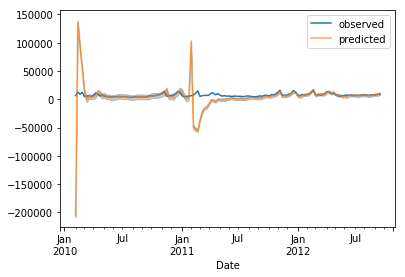

In [88]:
model_for_store3_exo = model_dict_2[3]

sales_store_3 = train.loc[idx[:, 3], 'sales']
sales_store_3.index = sales_store_3.index.droplevel('store')

predictions_store_3_exo = model_for_store3_exo.get_prediction(start=sales_store_3.index.min(), dynamic=False)

plot_predictions(sales_store_3, predictions_store_3_exo,  'sales')

#### Cross validation and train-test splits

### Using non time series methods

### Other more advanced packages

New stuff to try: Prophet, Bayesian Structural Time Series, Pyflux

#### Pyflux

[Pyflux documentation](https://pyflux.readthedocs.io/en/latest/index.html)
[Youtube lecture - Pyflux (advanced)](https://www.youtube.com/watch?v=JUctzSSAjG4)

In [ ]:
import pyflux as pflx

#### Facebook Prophet

[Prophet documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

Adding aditional data - called regressors:

https://facebook.github.io/prophet/docs/seasonality_and_holiday_effects.html

In [ ]:
from fbprophet import Prophet


In [ ]:
#Prophet requires data to have a timestamp column named ds and the target timeseries to be named y


def prepare_df_for_prophet_simple(_df, _name_of_target_column, name_of_timestamp)
    new_df_ = df.copy()
    new_df = new_df.reset_index()
    new_df_ = new_df_.rename(columns={name_of_timestamp: 'ds', _name_of_target_column: 'y'})
    new_df_ = new_df.loc[:, ['ds', 'y']]
    return new_df_


my_model = Prophet(interval_width=0.95)
my_model.fit(df)


In [ ]:
# utility functions to create:
from itertools import product


def make_cyclic_features(df_):
    #just an example - modify acordingly
    _X = df_.copy()
    _X['month (cosine)'] = np.cos(2 * np.pi * _X.index.month/ 12)
    _X['month (sin)'] = np.sin(2 * np.pi * _X.index.month/ 12)
    _X['decade (cosine)'] = np.cos(2 * np.pi * (_X.index.year % 10) / 10)
    _X['decade (sine)'] = np.sin(2 * np.pi * (_X.index.year % 10) / 10)
    return _X

def make_plots_of_target_vs_other(df_, target_name):
    for target, other in product([target_name], df_.drop(target_name, axis=1).columns): 
        df_[[target, other]].plot(figsize=(16, 6))
        plt.show()